# Workshop 2 - Implementation
    
In this notebook you will continue to implement the matrix method and check it with some sanity checks.

> ### Task 0
>
> Check whether your implementation of last week was correct using the provided solution

In [1]:
import numpy as np
import matrixmethod as mm
%config InlineBackend.figure_formats = ['svg']

%load_ext autoreload
%autoreload 2

## 1. The Node class
The `Node` class from last week is unchanged and complete

## 2. The Element class

The implementation is incomplete:
- The function `add_distributed_load` should compute the equivalent load vector for a constant load $q$ in $\bar x$ and $\bar z$ direction (we'll ignore a distributed moment load now) and moves those loads to the nodes belonging to the element. Remember to use the `add_load` function of the `Node` class to store the equivalent loads (remember we have two nodes per element). Also keep local/global transformations in mind and store `self.q = q` for later use;
- The function `bending_moments` receives the nodal displacements of the element in the global coordinate system (`u_global`) and uses it to compute the value of the bending moment at `num_points` equally-spaced points along the element length. Keep local/global transformations in mind and use the ODE approach in SymPy / Maple / pen and paper to compute an expression for $M$. Do the same for for $w$ in the function `full_displacement`.

> ### Task 2.1
>
> Add the missing pieces to the code, before you perform the checks below.

> ### Task 2.2
>
> Having made your implementations, it is now time to verify the first addition of your code with a simple sanity check. We would like to solve the following simply-supported beam:
> <center>
>  <figure>
>    <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/ssbeam.png" WIDTH=200>
>  </figure>
></center>
>
> Choose appropriate values yourself.
>
> Use the code blocks below to set up this problem. After you've added the load, print the element using `print(YOUR ELEMENT)`. Do the shown values for the nodal loads correspond with what you'd expect?

In [2]:
mm.Node.clear()
mm.Element.clear()

l = 2
EI = 1000
qz = 10
qx = 0
q = [qx, qz]

node1 = mm.Node(0,0)
node2 = mm.Node(l,0)

elem = mm.Element(node1, node2)

section = {}
section['EI'] = EI
elem.set_section(section)

elem.add_distributed_load(q)

In [3]:
print(elem)

Element connecting:
node #1:
 This node has:
 - x coordinate=0,
 - z coordinate=0,
 - degrees of freedom=[0, 1, 2],
 - load vector=[ 0.         10.         -3.33333333]
with node #2:
 This node has:
 - x coordinate=2,
 - z coordinate=0,
 - degrees of freedom=[3, 4, 5],
 - load vector=[ 0.         10.          3.33333333]


> ### Task 2.3
>  Now solve the nodal displacements. Once you are done, compare the rotation at the right end of the beam. Does it match the solution you already know?

In [4]:
con = mm.Constrainer()

con.fix_dof(node1,0)  # u1 = 0 (horizontaal)
con.fix_dof(node1,1)  # w1 = 0 (verticaal)
con.fix_dof(node2,1)  # w2 = 0 (verticaal)
print(con)

global_k = elem.stiffness()
global_f = np.zeros (6)

global_f[0:3] = node1.p
global_f[3:6] = node2.p 

K_ff, F_f = con.constrain (global_k, global_f)
u_f = np.matmul ( np.linalg.inv(K_ff), F_f )
print(u_f)

This constrainer has constrained the degrees of freedom: [0, 1, 4] with corresponding constrained values: [0, 0, 0])
[-0.00333333  0.          0.00333333]


> ### Task 2.4
> Calculate the bending moment at midspan and plot the moment distribution using `plot_moment_diagram`. Do the values and shape match with what you'd expect?

Moment bij midspan: 4.999999999999999


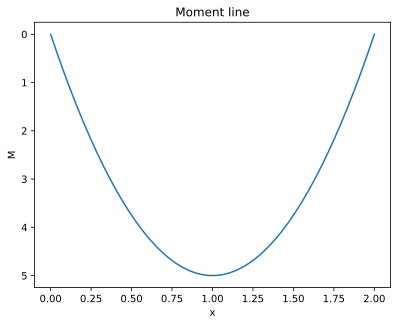

In [5]:
u_elem = con.full_disp(u_f)

M = elem.bending_moments(u_elem, num_points=3)
M_midspan = M[1]  # middelste punt
print("Moment bij midspan:", M_midspan)

elem.plot_moment_diagram(u_elem, num_points=50, scale=1.0)

> ### Task 2.5
> Calculate the deflection at midspan and plot the deflected structure using `plot_displaced`. Do the values and shape match with what you'd expect?

Displacement bij midspan: 0.0020833333333333333


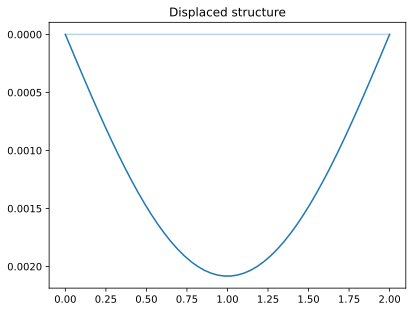

In [6]:
u, w = elem.full_displacement(u_elem, num_points=3)
w_midspan = w[1]  # middelste punt
print("Displacement bij midspan:", w_midspan)

elem.plot_displaced(u_elem, num_points=50)

## 3. The Constrainer class

We're going to expand our Constrainer class, but the implementation is incomplete:
- The constrainer class should be able to handle non-zero boundary conditions too. `constrain` should be adapted to do so + the docstring of the class itself. Furthermore, the assert statement of `fix_dof` should be removed.
- The function `support_reactions` is incomplete. Since the constrainer is always first going to get `constrain` called, here we already have access to `self.free_dofs`. Together with `self.cons_dofs`, you should have all you need to compute reactions. Note that `f` is also passed as argument. Make sure you take into account the contribution of equivalent element loads that go directly into the supports without deforming the structure.

> ### Task 3.1
>
> Add the missing pieces to the code and docstring, before you perform the checks below.

> ### Task 3.2
>
> We're going to verify our implementation. Therefore, we're going to solve an extension bar, supported at both ends, with a load $q$.
> <center>
>  <figure>
>    <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/sanitycheck_3.2.png" WIDTH=200>
>  </figure>
></center>
>
> Choose appropriate values yourself.
>
> Can you say on beforehand what will be the displacements? And what will be the support reactions?
> Use the code blocks below to set up and solve this problem and check the required quantities to make sure your implementation is correct.

In [9]:
mm.Node.clear()
mm.Element.clear()

l = 2
EA = 1000
qz = 0
qx = 10
q = [qx, qz]

node1 = mm.Node(0,0)
node2 = mm.Node(l,0)

elem = mm.Element(node1, node2)

section = {}
section['EA'] = EA
elem.set_section(section)

elem.add_distributed_load(q)

print(elem)

Element connecting:
node #1:
 This node has:
 - x coordinate=0,
 - z coordinate=0,
 - degrees of freedom=[0, 1, 2],
 - load vector=[10.  0.  0.]
with node #2:
 This node has:
 - x coordinate=2,
 - z coordinate=0,
 - degrees of freedom=[3, 4, 5],
 - load vector=[10.  0.  0.]


In [15]:
con = mm.Constrainer()

con.fix_dof(node1,0)  # u1 = 0 (horizontaal)
con.fix_dof(node1,1)  # w1 = 0 (verticaal)
con.fix_dof(node2,0)  # u2 = 0 (horizontaal)
con.fix_dof(node2,1)  # w2 = 0 (verticaal)

print(con)

global_k = elem.stiffness()
global_f = np.zeros (6)

global_f[0:3] = node1.p
global_f[3:6] = node2.p 

K_ff, F_new = con.constrain (global_k, global_f)
u_f = np.matmul (np.linalg.inv(K_ff), F_new)
print(u_f)

print(con.support_reactions(global_k,u_f,global_f))

This constrainer has constrained the degrees of freedom: [0, 1, 3, 4] with corresponding constrained values: [0, 0, 0, 0])
[0. 0.]
[-10.   0. -10.   0.]


> ### Task 3.3
>
> Again, we're going to verify our implementation. Therefore, we're going solve a beam, with a load $F$ and support displacement $\bar w$ for the right support.
> <center>
>  <figure>
>    <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/sanitycheck_3.3_new.png" WIDTH=200>
>  </figure>
></center>
>
> Choose appropriate values yourself.
>
> Use the code blocks below to set up and solve this problem and check the required quantities to make sure your implementation is correct.

In [19]:
EI = 1000
F  = 10
L  = 1
w_B = 0.1

mm.Node.clear()
mm.Element.clear()

node1 = mm.Node (0,0)
node2 = mm.Node (L,0)
node2.add_load([0,F,0])

elem = mm.Element ( node1, node2 )

section = {}
section['EI'] = EI

elem.set_section (section)

print(elem)

Element connecting:
node #1:
 This node has:
 - x coordinate=0,
 - z coordinate=0,
 - degrees of freedom=[0, 1, 2],
 - load vector=[0. 0. 0.]
with node #2:
 This node has:
 - x coordinate=1,
 - z coordinate=0,
 - degrees of freedom=[3, 4, 5],
 - load vector=[ 0. 10.  0.]


In [22]:
con = mm.Constrainer()

con.fix_node(node1) #volledig ingeklemd
con.fix_dof(node2,1, value = w_B)  # w2 = 0.1 (verticaal)

print(con)

global_k = elem.stiffness()
global_f = np.zeros (6)

global_f[0:3] = node1.p
global_f[3:6] = node2.p 

K_ff, F_new = con.constrain (global_k, global_f)
u_f = np.matmul (np.linalg.inv(K_ff), F_new)
print(u_f)

print(con.support_reactions(global_k,u_f,global_f))

This constrainer has constrained the degrees of freedom: [0, 1, 2, 4] with corresponding constrained values: [0, 0, 0, 0.1])
[ 0.   -0.15]
[   0. -300.  300.  290.]


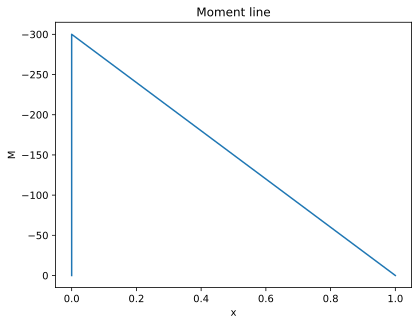

In [24]:
u_elem = con.full_disp(u_f)[elem.global_dofs()]
elem.plot_moment_diagram(u_elem,num_points=50)

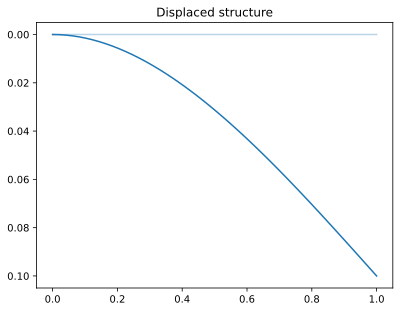

In [26]:
deflections = elem.full_displacement(u_elem,3)
elem.plot_displaced(u_elem,num_points=50)